In [1]:
import os
import sys
from pathlib import Path

PROJECT_DIR = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_DIR))

print("PROJECT_DIR:", PROJECT_DIR)


PROJECT_DIR: c:\Users\Abhishek Karyagol\OneDrive\Tài liệu\infosys\AI_Cricket_Player_Performance_Prediction


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import joblib
import json


In [3]:
from src.config import PROCESSED_DIR

df = pd.read_csv(PROCESSED_DIR / "dataset.csv")

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

print("Dataset loaded:", df.shape)
df.head()


Dataset loaded: (15842, 17)


,match_id,batter,runs,balls_faced,date,season,venue,team1,team2,winner,runs_last_5_avg,runs_last_10_avg,career_runs_avg,venue_runs_avg,pvt_runs_avg,pvp_runs_avg,target_next_runs
0,335982,Mohammad Hafeez,5,3,2008-04-18,2007/08,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,0.0,0.0,0.0,0.0,0.0,0.0,13.0
1,335982,Z Khan,3,8,2008-04-18,2007/08,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,0.0,0.0,0.0,0.0,0.0,0.0,17.0
2,335982,SC Ganguly,10,12,2008-04-18,2007/08,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,0.0,0.0,0.0,0.0,0.0,0.0,14.0
3,335982,P Kumar,18,17,2008-04-18,2007/08,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,0.0,0.0,0.0,0.0,0.0,0.0,34.0
4,335982,V Kohli,1,5,2008-04-18,2007/08,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,0.0,0.0,0.0,0.0,0.0,0.0,23.0


In [4]:
required_cols = [
    "batter", "venue", "team1", "team2",
    "runs_last_5_avg", "runs_last_10_avg", "career_runs_avg", "venue_runs_avg",
    "pvt_runs_avg", "pvp_runs_avg",
    "target_next_runs"
]

for col in required_cols:
    if col not in df.columns:
        df[col] = 0

print("Missing columns fixed if any.")


Missing columns fixed if any.


In [5]:
TARGET_COL = "target_next_runs"

feature_cols = [
    "batter", "venue", "team1", "team2",
    "runs_last_5_avg", "runs_last_10_avg", "career_runs_avg", "venue_runs_avg",
    "pvt_runs_avg", "pvp_runs_avg"
]

df = df.dropna(subset=[TARGET_COL]).copy()

print("Final training df:", df.shape)
df[feature_cols + [TARGET_COL, "date"]].head()


Final training df: (15842, 17)


,batter,venue,team1,team2,runs_last_5_avg,runs_last_10_avg,career_runs_avg,venue_runs_avg,pvt_runs_avg,pvp_runs_avg,target_next_runs,date
0,Mohammad Hafeez,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,0.0,0.0,0.0,0.0,0.0,0.0,13.0,2008-04-18
1,Z Khan,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,0.0,0.0,0.0,0.0,0.0,0.0,17.0,2008-04-18
2,SC Ganguly,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,0.0,0.0,0.0,0.0,0.0,0.0,14.0,2008-04-18
3,P Kumar,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,0.0,0.0,0.0,0.0,0.0,0.0,34.0,2008-04-18
4,V Kohli,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,0.0,0.0,0.0,0.0,0.0,0.0,23.0,2008-04-18


In [6]:
df = df.sort_values("date").reset_index(drop=True)

split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print("Train:", train_df.shape)
print("Test :", test_df.shape)

print("Train dates:", train_df["date"].min(), "->", train_df["date"].max())
print("Test dates :", test_df["date"].min(), "->", test_df["date"].max())


Train: (12673, 17)
Test : (3169, 17)
Train dates: 2008-04-18 00:00:00 -> 2021-10-15 00:00:00
Test dates : 2022-03-26 00:00:00 -> 2024-05-24 00:00:00


In [7]:
y_true = test_df[TARGET_COL].values
y_pred_baseline = test_df["runs_last_10_avg"].values

baseline_mae = mean_absolute_error(y_true, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
baseline_r2 = r2_score(y_true, y_pred_baseline)

print("📌 BASELINE (10-match rolling avg)")
print("MAE :", baseline_mae)
print("RMSE:", baseline_rmse)
print("R2  :", baseline_r2)


📌 BASELINE (10-match rolling avg)
MAE : 16.642361643300426
RMSE: 22.259228536399544
R2  : 0.040911567009834005


In [8]:
X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET_COL].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[TARGET_COL].copy()

cat_cols = ["batter", "venue", "team1", "team2"]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

print("Categorical cols:", cat_cols)
print("Numerical cols:", num_cols)


Categorical cols: ['batter', 'venue', 'team1', 'team2']
Numerical cols: ['runs_last_5_avg', 'runs_last_10_avg', 'career_runs_avg', 'venue_runs_avg', 'pvt_runs_avg', 'pvp_runs_avg']


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = ["batter", "venue", "team1", "team2"]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)


In [10]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("🌲 RANDOM FOREST")
print("MAE :", rf_mae)
print("RMSE:", rf_rmse)
print("R2  :", rf_r2)


🌲 RANDOM FOREST
MAE : 16.068422215209846
RMSE: 22.206670005624073
R2  : 0.04543542252257915


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = ["batter", "venue", "team1", "team2"]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])


In [13]:
rf_param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

rf_best = rf_grid.best_estimator_
rf_best_pred = rf_best.predict(X_test)

rf_best_mae = mean_absolute_error(y_test, rf_best_pred)
rf_best_rmse = np.sqrt(mean_squared_error(y_test, rf_best_pred))
rf_best_r2 = r2_score(y_test, rf_best_pred)

print("✅ Best RF Params:", rf_grid.best_params_)
print("🌲 RF (TUNED)")
print("MAE :", rf_best_mae)
print("RMSE:", rf_best_rmse)
print("R2  :", rf_best_r2)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Best RF Params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}
🌲 RF (TUNED)
MAE : 16.03581031056138
RMSE: 21.536837756969902
R2  : 0.10215305509416339


In [14]:
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print("⚡ XGBOOST")
print("MAE :", xgb_mae)
print("RMSE:", xgb_rmse)
print("R2  :", xgb_r2)


⚡ XGBOOST
MAE : 16.162195928721594
RMSE: 22.004321017365587
R2  : 0.06275230556450972


In [15]:
xgb_param_grid = {
    "model__n_estimators": [300, 600],
    "model__max_depth": [4, 6, 8],
    "model__learning_rate": [0.03, 0.05],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

xgb_best = xgb_grid.best_estimator_
xgb_best_pred = xgb_best.predict(X_test)

xgb_best_mae = mean_absolute_error(y_test, xgb_best_pred)
xgb_best_rmse = np.sqrt(mean_squared_error(y_test, xgb_best_pred))
xgb_best_r2 = r2_score(y_test, xgb_best_pred)

print("✅ Best XGB Params:", xgb_grid.best_params_)
print("⚡ XGB (TUNED)")
print("MAE :", xgb_best_mae)
print("RMSE:", xgb_best_rmse)
print("R2  :", xgb_best_r2)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
✅ Best XGB Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.03, 'model__max_depth': 4, 'model__n_estimators': 300, 'model__subsample': 0.8}
⚡ XGB (TUNED)
MAE : 16.085097865600922
RMSE: 21.537078657741628
R2  : 0.10213296920838655


In [16]:
lgbm_best = None
lgbm_best_mae = None
lgbm_best_rmse = None
lgbm_best_r2 = None

try:
    from lightgbm import LGBMRegressor

    lgbm_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            random_state=42
        ))
    ])

    lgbm_pipeline.fit(X_train, y_train)
    lgbm_pred = lgbm_pipeline.predict(X_test)

    lgbm_mae = mean_absolute_error(y_test, lgbm_pred)
    lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))
    lgbm_r2 = r2_score(y_test, lgbm_pred)

    print("🌟 LIGHTGBM")
    print("MAE :", lgbm_mae)
    print("RMSE:", lgbm_rmse)
    print("R2  :", lgbm_r2)

    lgbm_param_grid = {
        "model__n_estimators": [300, 600],
        "model__max_depth": [-1, 6, 10],
        "model__learning_rate": [0.03, 0.05]
    }

    lgbm_grid = GridSearchCV(
        lgbm_pipeline,
        lgbm_param_grid,
        cv=3,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1
    )

    lgbm_grid.fit(X_train, y_train)

    lgbm_best = lgbm_grid.best_estimator_
    lgbm_best_pred = lgbm_best.predict(X_test)

    lgbm_best_mae = mean_absolute_error(y_test, lgbm_best_pred)
    lgbm_best_rmse = np.sqrt(mean_squared_error(y_test, lgbm_best_pred))
    lgbm_best_r2 = r2_score(y_test, lgbm_best_pred)

    print("✅ Best LGBM Params:", lgbm_grid.best_params_)
    print("🌟 LGBM (TUNED)")
    print("MAE :", lgbm_best_mae)
    print("RMSE:", lgbm_best_rmse)
    print("R2  :", lgbm_best_r2)

except Exception as e:
    print("❌ LightGBM not installed or error.")
    print("Reason:", str(e))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2012
[LightGBM] [Info] Number of data points in the train set: 12673, number of used features: 247
[LightGBM] [Info] Start training from score 20.065888


c:\Users\Abhishek Karyagol\.conda\envs\cricket310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


🌟 LIGHTGBM
MAE : 16.18872994939474
RMSE: 21.97274593299165
R2  : 0.06544018148638475
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2012
[LightGBM] [Info] Number of data points in the train set: 12673, number of used features: 247
[LightGBM] [Info] Start training from score 20.065888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Abhishek Karyagol\.conda\envs\cricket310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [17]:
results = [
    ("Baseline (runs_last_10_avg)", baseline_mae, baseline_rmse, baseline_r2),
    ("RandomForest", rf_mae, rf_rmse, rf_r2),
    ("RandomForest Tuned", rf_best_mae, rf_best_rmse, rf_best_r2),
    ("XGBoost", xgb_mae, xgb_rmse, xgb_r2),
    ("XGBoost Tuned", xgb_best_mae, xgb_best_rmse, xgb_best_r2),
]

if lgbm_best is not None:
    results.append(("LightGBM Tuned", lgbm_best_mae, lgbm_best_rmse, lgbm_best_r2))

results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])
results_df.sort_values("RMSE")


,Model,MAE,RMSE,R2
2,RandomForest Tuned,16.035810,21.536838,0.102153
4,XGBoost Tuned,16.085098,21.537079,0.102133
5,LightGBM Tuned,16.081482,21.601653,0.096741
3,XGBoost,16.162196,22.004321,0.062752
1,RandomForest,16.068422,22.206670,0.045435
0,Baseline (runs_last_10_avg),16.642362,22.259229,0.040912


In [18]:
best_model = xgb_best
best_model_name = "xgb_model"
best_rmse = xgb_best_rmse

if rf_best_rmse < best_rmse:
    best_model = rf_best
    best_model_name = "rf_model"
    best_rmse = rf_best_rmse

if lgbm_best is not None and lgbm_best_rmse < best_rmse:
    best_model = lgbm_best
    best_model_name = "lgbm_model"
    best_rmse = lgbm_best_rmse

print("✅ BEST MODEL:", best_model_name)
print("✅ BEST RMSE:", best_rmse)


✅ BEST MODEL: rf_model
✅ BEST RMSE: 21.536837756969902


In [19]:
from src.config import PROJECT_DIR

models_dir = PROJECT_DIR / "models"
models_dir.mkdir(exist_ok=True)

model_path = models_dir / f"{best_model_name}.joblib"
joblib.dump(best_model, model_path)

metrics = {
    "baseline": {"mae": baseline_mae, "rmse": baseline_rmse, "r2": baseline_r2},
    "rf_tuned": {"mae": rf_best_mae, "rmse": rf_best_rmse, "r2": rf_best_r2},
    "xgb_tuned": {"mae": xgb_best_mae, "rmse": xgb_best_rmse, "r2": xgb_best_r2},
    "lgbm_tuned": {"mae": lgbm_best_mae, "rmse": lgbm_best_rmse, "r2": lgbm_best_r2},
    "best_model": best_model_name
}

with open(models_dir / "training_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

with open(models_dir / "tuning_best_params.json", "w") as f:
    json.dump({
        "rf_best_params": rf_grid.best_params_,
        "xgb_best_params": xgb_grid.best_params_,
    }, f, indent=4)

print("✅ Saved model:", model_path)
print("✅ Saved metrics:", models_dir / "training_metrics.json")
print("✅ Saved tuning params:", models_dir / "tuning_best_params.json")


✅ Saved model: C:\Users\Abhishek Karyagol\OneDrive\Tài liệu\infosys\AI_Cricket_Player_Performance_Prediction\models\rf_model.joblib
✅ Saved metrics: C:\Users\Abhishek Karyagol\OneDrive\Tài liệu\infosys\AI_Cricket_Player_Performance_Prediction\models\training_metrics.json
✅ Saved tuning params: C:\Users\Abhishek Karyagol\OneDrive\Tài liệu\infosys\AI_Cricket_Player_Performance_Prediction\models\tuning_best_params.json


✅ SHAP values computed successfully


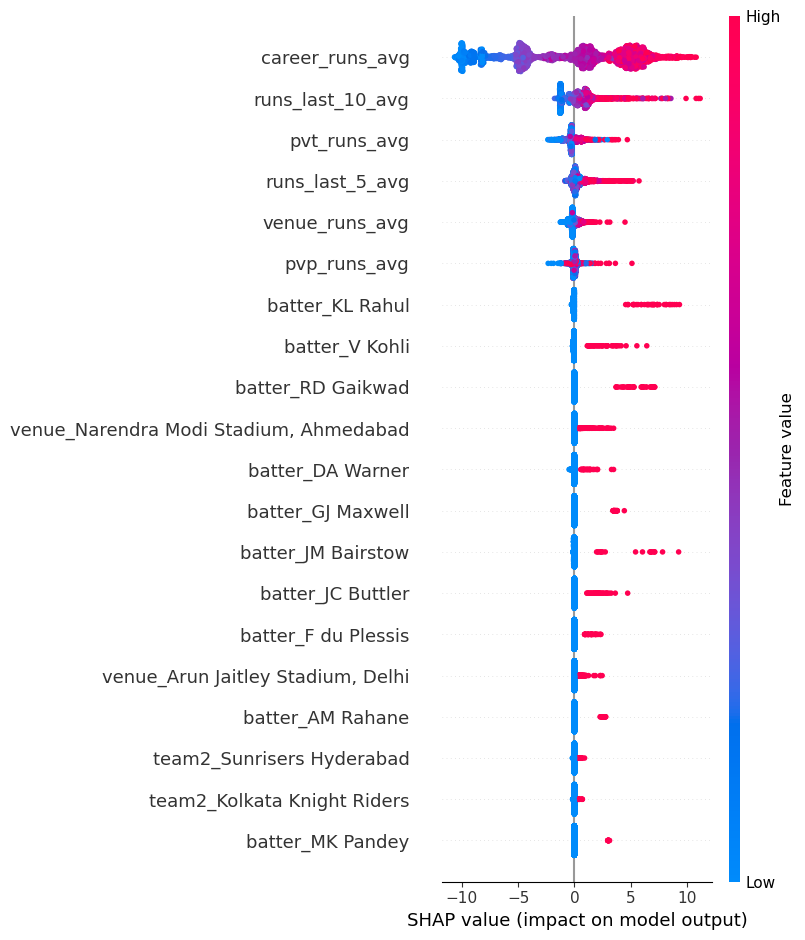

In [21]:
try:
    import shap
    import numpy as np

    # Transform X_test using pipeline preprocessor
    X_test_transformed = best_model.named_steps["preprocessor"].transform(X_test)

    # Convert sparse -> dense if needed
    if hasattr(X_test_transformed, "toarray"):
        X_test_dense = X_test_transformed.toarray()
    else:
        X_test_dense = np.array(X_test_transformed)

    # Feature names
    ohe = best_model.named_steps["preprocessor"].named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    all_feature_names = list(cat_feature_names) + num_cols

    # Use TreeExplainer for tree models
    explainer = shap.TreeExplainer(best_model.named_steps["model"])
    shap_values = explainer.shap_values(X_test_dense)

    print("✅ SHAP values computed successfully")

    shap.summary_plot(shap_values, X_test_dense, feature_names=all_feature_names)

except Exception as e:
    print("❌ SHAP not installed or error.")
    print("Reason:", str(e))


In [1]:
import os
print(os.getcwd())

c:\Users\Abhishek Karyagol\Documents\AI_Cricket_Player_Performance_Prediction\notebooks
